# `PyKalshi` — The Kalshi Python Client

## [Open in Colab](https://colab.research.google.com/drive/1cD1FJZSeEW2qThzi7IZQKtHxu3z3eWAO?usp=sharing#scrollTo=bke-lcXOXTNC)

A typed, ergonomic Python client for the [Kalshi](https://kalshi.com) prediction markets API.  
First-class domain objects, real-time WebSocket streaming, built-in orderbook analytics, and rich notebook rendering, all in one library.


**This notebook can run against Kalshi's demo environment risk-free**.  
Get your demo API key at [https://help.kalshi.com/account/demo-account](https://help.kalshi.com/account/demo-account).

<small>*The demo platform may have low volume and inconsistent pricing </small>

In [1]:
%pip install --upgrade pykalshi -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.5/47.5 kB 1.9 MB/s eta 0:00:00


# Authentication

### Option 1: Set credentials directly
```
os.environ["KALSHI_API_KEY_ID"] = "your-key-id"
os.environ["KALSHI_PRIVATE_KEY_PATH"] = "/path/to/your/private_key.pem"
```


### Option 2: Load from .env file
Sample my.env
```
KALSHI_API_KEY_ID=...
KALSHI_PRIVATE_KEY_PATH=private-key.key
```

In [2]:
import os
from pykalshi import KalshiClient


from dotenv import load_dotenv
load_dotenv("my.env")

client = KalshiClient(demo=False)
client.exchange.get_status()

Exchange,active
Trading,active


---
## Market Discovery

Retrieve and filter markets with various parameters

Or directly fetch a target market using it's ticker


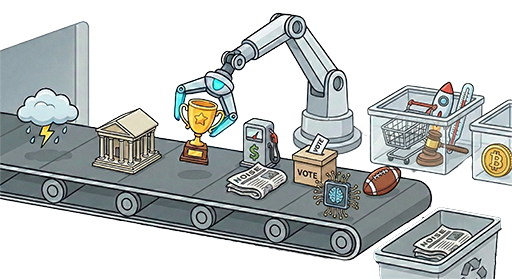

Browse open markets and pick one with activity

In [8]:
from pykalshi import MarketStatus

markets = client.get_markets(status=MarketStatus.OPEN, limit=200, mve_filter="exclude")

market = max([m for m in markets if m.liquidity > 0], key=lambda x: x.volume_24h)

market

Ticker,KXNCAAMBSPREAD-26FEB07KSUTCU-TCU9
Title,TCU wins by over 9.5 Points?
Status,active
YES,50¢ / 52¢
Last,55¢
Volume,219
Open Int,219
Closes,"Feb 21, 19:00"


### Using a predefined ticker


In [9]:
series = client.get_series("kxpresperson")
event = series.get_events()[0]
event

Event,KXPRESPERSON-28
Series,KXPRESPERSON
Title,Next U.S. Presidential Election Winner?
Category,Elections
Exclusive,✓


Find market with most volume in the event

In [10]:
max_volume_market = max(event.get_markets(), key=lambda x: x.volume)

market = max_volume_market
market

Ticker,KXPRESPERSON-28-GNEWS
Title,Who will win the next presidential election?
Status,active
YES,20¢ / 21¢
Last,21¢
Volume,"1,123,093"
Open Int,"680,890"
Closes,"Nov 07, 15:00"


---
## Orderbook Analytics

The orderbook comes with computed analytics out of the box:  **spread**, **mid**, **VWAP**, **imbalance**, and **depth**.

In [11]:
ob = market.get_orderbook(depth=7)
ob

OrderbookResponse(orderbook=Orderbook(yes=[(14, 1028), (15, 1040), (16, 11000), (17, 22943), (18, 29990), (19, 117787), (20, 1593)], no=[(70, 10), (73, 32), (75, 819), (76, 4012), (77, 10466), (78, 20653), (79, 123966)], yes_dollars=[('0.1400', 1028), ('0.1500', 1040), ('0.1600', 11000), ('0.1700', 22943), ('0.1800', 29990), ('0.1900', 117787), ('0.2000', 1593)], no_dollars=[('0.7000', 10), ('0.7300', 32), ('0.7500', 819), ('0.7600', 4012), ('0.7700', 10466), ('0.7800', 20653), ('0.7900', 123966)]), orderbook_fp=OrderbookFp(yes_dollars=[('0.1400', 1028), ('0.1500', 1040), ('0.1600', 11000), ('0.1700', 22943), ('0.1800', 29990), ('0.1900', 117787), ('0.2000', 1593)], no_dollars=[('0.7000', 10), ('0.7300', 32), ('0.7500', 819), ('0.7600', 4012), ('0.7700', 10466), ('0.7800', 20653), ('0.7900', 123966)]))

In [12]:
print(f"Spread:    {ob.spread}¢")
print(f"Mid:       {ob.mid}¢")
print(f"Imbalance: {ob.imbalance:+.2f}"  if ob.imbalance else "Imbalance: N/A")

Spread:    1¢
Mid:       20.5¢
Imbalance: +0.07


Cost to buy 50 contracts based on current orderbook

In [13]:
from pykalshi import Side
vwap = ob.vwap_to_fill("yes", size=50)
print(f"VWAP (50 YES): {vwap:.1f}¢" if vwap else "Insufficient liquidity for 50")

VWAP (50 YES): 21.0¢


---
## First-Class Order Objects

**Objects don't just contain data, they have methods.**  
Place, amend, cancel, and wait for fills directly on the order itself.

> All orders below use 1¢ prices — they'll rest on the book but never fill.

In [14]:
from pykalshi import Action, Side, OrderType

order = client.portfolio.place_order(
    ticker=market.ticker,
    action=Action.BUY,
    side=Side.YES,
    count=5,
    yes_price=1,  # 1¢ - won't fill
)
order

Order ID,a238e47c-99bd-43...
Ticker,KXPRESPERSON-28-GNEWS
Side,BUY YES
Price,1¢
Filled,0/5 (0%)
Status,resting
Created,"Feb 06, 23:37"


Amend price, returns self with updated state


In [15]:
order.amend(yes_price=2)
order

Order ID,a238e47c-99bd-43...
Ticker,KXPRESPERSON-28-GNEWS
Side,BUY YES
Price,2¢
Filled,0/5 (0%)
Status,resting
Created,"Feb 06, 23:37"


Cancel

In [16]:
order.cancel()
order

Order ID,a238e47c-99bd-43...
Ticker,KXPRESPERSON-28-GNEWS
Side,BUY YES
Price,2¢
Filled,0/5 (0%)
Status,canceled
Created,"Feb 06, 23:37"


### Batch Operations

Place or cancel multiple orders atomically, all succeed or all fail.

In [17]:
orders = client.portfolio.batch_place_orders([
    {"ticker": market.ticker, "action": "buy", "side": "yes", "type": "limit", "count": 1, "yes_price": 1},
    {"ticker": market.ticker, "action": "buy", "side": "yes", "type": "limit", "count": 1, "yes_price": 2},
    {"ticker": market.ticker, "action": "buy", "side": "yes", "type": "limit", "count": 1, "yes_price": 3},
])

canceled_batch = client.portfolio.batch_cancel_orders([o.order_id for o in orders])

for order in canceled_batch:
  display(order)
  print('='*20)

Order ID,86e6464b-67ea-49...
Ticker,KXPRESPERSON-28-GNEWS
Side,BUY YES
Price,1¢
Filled,0/1 (0%)
Status,canceled
Created,"Feb 06, 23:37"


Order ID,f12edf8c-7f37-4f...
Ticker,KXPRESPERSON-28-GNEWS
Side,BUY YES
Price,2¢
Filled,0/1 (0%)
Status,canceled
Created,"Feb 06, 23:37"


Order ID,117c9913-d9d4-41...
Ticker,KXPRESPERSON-28-GNEWS
Side,BUY YES
Price,3¢
Filled,0/1 (0%)
Status,canceled
Created,"Feb 06, 23:37"


---
## Pandas in One Line

Every list result has `.to_dataframe()` -- positions, fills, orders, markets, candlesticks, even orderbooks.

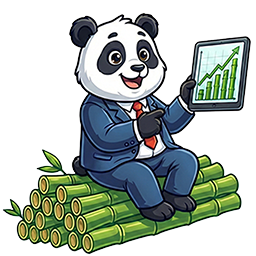

In [18]:
client.get_markets(status=MarketStatus.OPEN, limit=10).to_dataframe()[
["ticker", "title", "yes_bid", "yes_ask", "volume", "open_interest"]
]

,ticker,title,yes_bid,yes_ask,volume,open_interest
0,KXMVESPORTSMULTIGAMEEXTENDED-S20262F0CFA0732B-...,"yes Mikal Bridges: 3+,yes Jalen Brunson: 30+,y...",0,0,0,0
1,KXMVESPORTSMULTIGAMEEXTENDED-S2026FADF251CDBC-...,"yes TreVeyon Henderson,yes Jaxon Smith-Njigba,...",0,0,0,0
2,KXMVESPORTSMULTIGAMEEXTENDED-S20261A86C7AADE4-...,"yes Pascal Siakam: 20+,yes Julius Randle: 20+,...",0,37,0,0
3,KXMVESPORTSMULTIGAMEEXTENDED-S20266CB14CED86B-...,"yes Derrick White: 4+,yes Cade Cunningham: 8+,...",0,0,0,0
4,KXMVESPORTSMULTIGAMEEXTENDED-S2026CE547B25DC6-...,"yes Arkansas,yes Texas,yes Georgetown,yes Indi...",0,0,0,0
5,KXMVESPORTSMULTIGAMEEXTENDED-S2026138192C4B3B-...,"yes Jaxon Smith-Njigba,yes Kenneth Walker III,...",0,8,0,0
6,KXMVESPORTSMULTIGAMEEXTENDED-S2026096E8B5162A-...,"yes Jalen Brunson: 3+,no Detroit wins by over ...",0,12,0,0
7,KXMVESPORTSMULTIGAMEEXTENDED-S20265636D849573-...,"yes Pascal Siakam: 2+,yes Zach LaVine: 1+,yes ...",0,9,0,0
8,KXMVESPORTSMULTIGAMEEXTENDED-S2026F8C21C4AE24-...,"yes Sam Darnold: 200+,yes Kayshon Boutte: 20+,...",0,20,0,0
9,KXMVESPORTSMULTIGAMEEXTENDED-S2026F12E6C8ADD1-...,"yes Jalen Brunson: 6+,yes New York,yes Derrick...",0,0,0,0


In [19]:
market.get_orderbook(depth=5).to_dataframe()

,side,price,quantity
0,yes,20,1593
1,yes,19,117787
2,yes,18,29990
3,yes,17,22943
4,yes,16,11000
5,no,79,123966
6,no,78,20653
7,no,77,10466
8,no,76,4012
9,no,75,819


In [20]:
from pykalshi import CandlestickPeriod
from datetime import datetime, timedelta

end = int(datetime.now().timestamp())
start = int((datetime.now() - timedelta(days=360)).timestamp())

candles = market.get_candlesticks(start_ts=start, end_ts=end, period=CandlestickPeriod.ONE_DAY)
candles.to_dataframe().tail(5)

,ticker,end_period_ts,volume,open_interest,open,high,low,close,mean,timestamp
267,KXPRESPERSON-28-GNEWS,1770008400,4861,666225,20.0,21.0,19.0,21.0,20.0,2026-02-02 05:00:00
268,KXPRESPERSON-28-GNEWS,1770094800,2507,668326,21.0,21.0,19.0,20.0,20.0,2026-02-03 05:00:00
269,KXPRESPERSON-28-GNEWS,1770181200,3410,670890,20.0,20.0,19.0,20.0,19.0,2026-02-04 05:00:00
270,KXPRESPERSON-28-GNEWS,1770267600,2139,672108,20.0,20.0,19.0,20.0,19.0,2026-02-05 05:00:00
271,KXPRESPERSON-28-GNEWS,1770354000,2243,673388,19.0,20.0,19.0,19.0,19.0,2026-02-06 05:00:00


### Candlestick Chart with Volume

One `.to_dataframe()` call and a few lines of plotly.

In [21]:
# @title
import plotly.graph_objects as go
from plotly.subplots import make_subplots

df = candles.to_dataframe()

fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.03,
    row_heights=[0.7, 0.3],
)

# Candlesticks
fig.add_trace(
    go.Candlestick(
        x=df["timestamp"],
        open=df["open"],
        high=df["high"],
        low=df["low"],
        close=df["close"],
        increasing_line_color="#22c55e",
        decreasing_line_color="#ef4444",
        name="Price",
    ),
    row=1, col=1,
)

# Volume bars — colored by direction
colors = [
    "#22c55e" if c >= o else "#ef4444"
    for c, o in zip(df["close"], df["open"])
]
fig.add_trace(
    go.Bar(
        x=df["timestamp"],
        y=df["volume"],
        marker_color=colors,
        opacity=0.5,
        name="Volume",
    ),
    row=2, col=1,
)

fig.update_layout(
    title=f"{market.ticker}  —  Daily",
    template="plotly_dark",
    height=500,
    showlegend=False,
    xaxis_rangeslider_visible=False,
    margin=dict(l=50, r=20, t=50, b=30),
    yaxis=dict(title="Price (¢)", side="right"),
    yaxis2=dict(title="Volume", side="right"),
)

fig.show()

---
## Portfolio

Balance, positions, fills, and settlements all have html rendering and `.to_dataframe()`.

In [22]:
client.portfolio.get_balance()

Balance,$10.56
Portfolio,$5.04


In [23]:
positions = client.portfolio.get_positions()
positions.to_dataframe()


,ticker,position,market_exposure,total_traded,resting_orders_count,fees_paid,realized_pnl,last_updated_ts
0,KXPRESPERSON-28-GNEWS,0,0,0,0,0,0,2026-02-06T03:05:25.166814Z
1,KXELONMARS-99,0,0,0,0,0,0,2025-12-15T01:13:06.726217Z
2,OAIAGI-29,-8,441,441,0,14,0,2025-10-19T18:09:09.810019Z


In [24]:
fills = client.portfolio.get_fills(limit=5)
fills.to_dataframe()


,trade_id,ticker,order_id,side,action,count,yes_price,no_price,is_taker,fill_id,market_ticker,fee_cost,created_time,ts
0,574357e9-8e29-75f0-097a-3c84c4f78635,KXNFLGAME-26JAN18SFSEA-SF,913aab0b-c167-4c5b-a83c-8388f62e40b5,yes,buy,117,4,96,True,574357e9-8e29-75f0-097a-3c84c4f78635,KXNFLGAME-26JAN18SFSEA-SF,0.3200,2026-01-18T03:13:33.217487Z,1768706013
1,479758af-055e-7ca2-ea24-eb3c9f39964f,KXLEAVEBIER-26JAN01,ba92d202-0617-454c-968d-9caaf6a8041f,no,buy,5,2,98,False,479758af-055e-7ca2-ea24-eb3c9f39964f,KXLEAVEBIER-26JAN01,0.0000,2025-12-31T01:57:48.548284Z,1767146268
2,ccd385b1-f32b-758d-5b44-c39848b70619,KXWAYMOCITIES-25-4,ca71bad5-43f3-4cee-b3c3-e597a1877645,yes,buy,1,85,15,True,ccd385b1-f32b-758d-5b44-c39848b70619,KXWAYMOCITIES-25-4,0.0100,2025-10-19T18:59:25.539107Z,1760900365
3,38bcc07d-d64a-41bc-be8d-0b3b704f63fb,KXAIAUTHOR-25,5cbc74a3-7f0f-42f0-8fbf-aef349af2229,no,buy,5,3,97,True,38bcc07d-d64a-41bc-be8d-0b3b704f63fb,KXAIAUTHOR-25,0.0200,2025-10-19T18:22:19.945202Z,1760898139
4,fca7a3bc-f3d6-662d-5bf3-a4b8247fe168,OAIAGI-29,3d25a0e5-c3cc-4ba0-b371-5da2c793af2d,no,buy,1,44,56,True,fca7a3bc-f3d6-662d-5bf3-a4b8247fe168,OAIAGI-29,0.0100,2025-10-19T18:09:09.809718Z,1760897349


---
## WebSocket Streaming

Real-time price updates with a decorator-based API.  
Auto-reconnects, typed messages, and health metrics, all handled for you.

In [25]:
import time

feed = client.feed()
updates = []

@feed.on("ticker")
def on_price(msg):
    updates.append(msg)
    print(f"  {msg.market_ticker}: {msg.yes_bid}/{msg.yes_ask}  vol={msg.volume}")

feed.subscribe("ticker", market_ticker=market.ticker)
feed.start()

print(f"Streaming {market.ticker} for 10 seconds...\n")
time.sleep(10)

feed.stop()
print(f"\nReceived {len(updates)} updates | Latency: {feed.latency_ms:.0f}ms" if feed.latency_ms else f"\nReceived {len(updates)} updates")

Streaming KXPRESPERSON-28-GNEWS for 10 seconds...


Received 0 updates


### Context Manager Pattern

Use `with` for automatic cleanup — the feed stops when you leave the block.

In [26]:
with client.feed() as feed:
    prices = []

    @feed.on("ticker")
    def collect(msg):
        prices.append((msg.market_ticker, msg.yes_bid, msg.yes_ask))

    feed.subscribe("ticker", market_ticker=market.ticker)
    time.sleep(5)

print(f"Collected {len(prices)} snapshots")
if prices:
    print(f"Last: ticker={prices[-1][0]}, bid={prices[-1][1]}, ask={prices[-1][2]}")

Collected 0 snapshots


---
## Local Orderbook Manager

Maintain a **real-time local orderbook** from WebSocket deltas.  
Calculates spread, mid, imbalance, and cost-to-fill, all updated live.

In [27]:
from pykalshi import OrderbookManager, OrderbookSnapshotMessage

book = OrderbookManager(market.ticker)

with client.feed() as feed:
    @feed.on("orderbook_delta")
    def handle(msg):
        if isinstance(msg, OrderbookSnapshotMessage):
            book.apply_snapshot(msg.yes, msg.no)
            print(f"  Snapshot: {len(book.yes)} bid levels, {len(book.no)} ask levels")
        else:
            book.apply_delta(msg.side, msg.price, msg.delta)
            print(f"  Delta: {msg.side} {msg.price}¢ {msg.delta:+d}  →  spread={book.spread}¢  mid={book.mid}")

    feed.subscribe("orderbook_delta", market_ticker=market.ticker)
    print(f"Tracking {market.ticker} orderbook for 10 seconds...\n")
    time.sleep(10)

# Final state
print(f"\nFinal: bid={book.best_bid}¢  ask={book.best_ask}¢  spread={book.spread}¢")

cost = book.cost_to_buy(10)
if cost:
    print(f"Cost to buy 10 YES: {cost[0]}¢ (avg {cost[1]:.1f}¢)")

Tracking KXPRESPERSON-28-GNEWS orderbook for 10 seconds...

  Snapshot: 18 bid levels, 36 ask levels

Final: bid=20¢  ask=21¢  spread=1¢
Cost to buy 10 YES: 210¢ (avg 21.0¢)


---
## Error Handling

Typed exceptions with full request context, for simpler debugging.

In [28]:
from pykalshi.exceptions import ResourceNotFoundError, KalshiAPIError

try:
    client.get_market("DOESNOTEXIST-123")
except ResourceNotFoundError as e:
    print(f"Caught: {type(e).__name__}")
    print(f"Status:  {e.status_code}")
    print(f"Message: {e.message}")

ERROR:pykalshi.client:Response 404: Error body: {"error":{"code":"not_found","message":"not found","service":"query-exchange"}}


Caught: ResourceNotFoundError
Status:  404
Message: Unknown Error


---

### What else can pykalshi do?

| Feature | Example |
|---|---|
| **Automatic pagination** | `client.get_markets(fetch_all=True)` |
| **Proactive rate limiting** | `KalshiClient(rate_limiter=RateLimiter(10))` |
| **Auto-retry on 429/5xx** | Built-in exponential backoff |
| **Subaccounts** | Isolate capital across strategies |
| **Order groups** | Auto-cancel when contract limits hit |
| **Queue positions** | See where you sit in the book |
| **Candlestick batching** | OHLC for up to 100 tickers in one call |
| **`order.wait_until_terminal()`** | Block until filled or canceled |

Full docs and source: [github.com/ArshKA/pykalshi](https://github.com/ArshKA/pykalshi)